# Text-to-SQL Supabase Query Assistant

## Project Overview

This project implements an end-to-end workflow that lets a user:

1. Write a **natural-language request** (e.g. “Show me all accounts with level greater than 2”).
2. Have an **LLM-based sub‑agent** translate that request into a **PostgreSQL query**.
3. Safely execute the query against a **Supabase (PostgreSQL) database**.
4. Display the results cleanly as a **table** (pandas DataFrame).

The core components are:

- A **Text‑to‑SQL generator** (`GenerateSQLCodeFromText` tool).
- An **orchestrating agent** (`sql-code-generator` sub‑agent via `deepagents`).
- A **database execution layer** (`QueryTheDatabaseAndShowTheOutput`).
- A **simple runner** (`RunUserRequest`) that ties the whole workflow together.

The target database is a Supabase-hosted PostgreSQL instance containing accounting-related tables (`accounts`, `journal_entries`, `journal_lines`, `ledger_entries`).

---

## Architecture

- ### High-Level Flow

1. **User** provides a prompt (plain text), e.g.:

   > “Show me all account columns whose account level is greater than 2.”

2. **Controller Agent** (`agent`) receives this message and delegates it to an internal **SQL generator sub‑agent** (`sql-code-generator`).

3. **SQL generator sub‑agent**:
   - Uses the `GenerateSQLCodeFromText` tool to:
     - Read the **database documentation** from `database guide.md` (if available).
     - Construct a **system + human prompt** for Text‑to‑SQL.
     - Call an OpenAI model (`gpt-4o-mini`) and get a **structured** output (`Text_TO_Code`).
   - Optionally uses `think_tool` for internal reflection (not required by the current controller).
   - Returns the final **SQL string** to the controller.

4. **Controller Agent** passes the SQL back as the final answer.

5. **Execution Layer** (`QueryTheDatabaseAndShowTheOutput`):
   - Cleans the SQL (removes ```sql code fences if present).
   - Checks for **destructive statements** (DROP, TRUNCATE, DELETE, UPDATE, INSERT) and refuses to run them.
   - Connects to Supabase PostgreSQL with `psycopg2`.
   - Executes the SQL, retrieves results, and displays them in a pandas DataFrame.



- ### Main Components

| Component                                | Responsibility                                                |
|------------------------------------------|--------------------------------------------------------------|
| `Text_TO_Code` (Pydantic model)         | Defines structured output from the Text‑to‑SQL tool         |
| `BuildText2SqlMessages`                 | Builds system + human messages for Text‑to‑SQL              |
| `GenerateSQLCodeFromText` (tool)        | Calls LLM to convert text → SQL (`Text_TO_Code`)            |
| `think_tool` (tool)                     | Optional reflection helper for reasoning                    |
| `sql-code-generator` sub‑agent          | Uses the above tools under SQL-specific instructions        |
| `agent` (deep agent)                    | Top-level orchestrator; delegates user requests to sub‑agent|
| `QueryTheDatabaseAndShowTheOutput`      | Executes SQL safely against Supabase and displays results   |
| `RunUserRequest`                        | Convenience function tying LLM generation + execution       |


---

### 1. Core Imports and Configuration

In [ ]:
import os
import psycopg2
import psycopg2.extras
import pandas as pd
from IPython.display import Image, display

# LangChain/LangGraph Imports
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing_extensions import NotRequired, TypedDict

# API Configuration
GPT4o_mini = "sk-proj-***"  # OpenAI API Key


**Explanation:**
- **`psycopg2`**: PostgreSQL database adapter for Python
- **`pandas`**: Data manipulation and display library for clean output formatting
- **LangChain/LangGraph**: Framework for building AI agents with tools and memory
- **Pydantic**: Data validation and settings management

---

### 2. Data Models and Structured Output

In [2]:
class Text_TO_Code(BaseModel):
    """Structured output for generated SQL code."""
    sql: str = Field(description="The generated SQL query as a string")

**Explanation:**
- **`Text_TO_Code`** is a Pydantic model that defines the structured output format
- Ensures the AI always returns both SQL code and an optional description
- Provides type safety and validation for the AI's responses

---

### 3. SQL Generation System

#### 3.1 Prompt Templates

In [3]:
# Text-to-SQL prompt templates and helper
TEXT2SQL_SYSTEM_PROMPT = """You are an expert Text-to-SQL generator.

Given a user request and database documentation, produce a single, correct SQL query.

Database documentation:
{database_docs}

Rules:
- Target SQL dialect: {dialect}.
- Use only tables/columns that exist in the documentation. Do not invent anything.
- Prefer readable SQL with CTEs over overly nested queries.
- If filters/aggregations are ambiguous, choose the most reasonable interpretation.
- If the request lacks critical details, ask ONE concise clarifying question instead of guessing.
- Avoid destructive statements (DROP/DELETE/TRUNCATE/UPDATE) unless explicitly requested.
- If the user asks for results (not schema changes), include a LIMIT {default_limit} unless the query already has LIMIT or is an aggregation with GROUP BY.
- For dates, use ISO format (YYYY-MM-DD).

You will return a structured object with two fields:
- 'sql': the final SQL query as a string.
- 'description': a short explanation of what the query does (optional).
"""


TEXT2SQL_HUMAN_PROMPT = "User request:\n{user_request}\n"

**Explanation:**
- **System prompt** provides context and rules to the AI model
- **`{database_docs}`**: Placeholder for database schema loaded from file
- **Safety rules**: Prevents destructive operations and ensures proper limits
- **Structured output**: Forces consistent response format

#### 3.2 Message Builder Function

In [4]:
def BuildText2SqlMessages(
    user_request: str,
    *,
    dialect: str = "PostgreSQL",
    default_limit: int = 100,
) -> list:
    """
    Build SystemMessage and HumanMessage for a Text-to-SQL task.
    """
    try:
        with open("database guide.md", "r", encoding="utf-8") as f:
            database_docs = f.read()
    except FileNotFoundError:
        database_docs = (
            "WARNING: No database guide.md found. You must infer the schema only from "
            "the user request and keep the SQL as generic PostgreSQL."
        )
    except Exception as e:
        database_docs = f"WARNING: Error reading database documentation: {e}"

    sys_msg = SystemMessage(
        content=TEXT2SQL_SYSTEM_PROMPT.format(
            database_docs=database_docs,
            dialect=dialect,
            default_limit=default_limit,
        )
    )
    human_msg = HumanMessage(
        content=TEXT2SQL_HUMAN_PROMPT.format(user_request=user_request)
    )
    return [sys_msg, human_msg]

**Explanation:**
- **File I/O**: Reads the database schema guide file
- **Error handling**: Gracefully handles missing schema files
- **Message construction**: Creates proper LangChain message objects for the AI
- **Parameterization**: Allows customization of SQL dialect and result limits

---

### 4. Core Tools

#### 4.1 SQL Generation Tool

In [5]:
@tool(parse_docstring=True)
def GenerateSQLCodeFromText(user_text: str) -> Text_TO_Code:
    """ 
    Generate SQL code from a user's natural-language request.

    Args: 
        user_text: User's natural language request for generating SQL code.

    Returns:
        Text_TO_Code object containing the generated SQL code and an optional description.
    """
    messages = BuildText2SqlMessages(user_text)

    model = init_chat_model(
        model="openai:gpt-4o-mini",
        api_key=GPT4o_mini
    )

    structured_model = model.with_structured_output(Text_TO_Code)

    try:
        # Here we call the model with the message list directly
        result = structured_model.invoke(messages)
        return result
    except Exception as e:
        # You might want to raise or log instead of just printing
        print(f"Error generating SQL: {e}")
        # Return a fallback object (empty SQL) so caller can handle it
        return Text_TO_Code(sql="", description=f"Error generating SQL: {e}")

**Explanation:**
- **`@tool` decorator**: Makes this function available to the AI agent as a tool
- **Model initialization**: Creates a connection to OpenAI's GPT-4o-mini
- **Structured output**: Forces the model to return data in the `Text_TO_Code` format
- **Error handling**: Returns empty SQL with error message if generation fails

#### 4.2 Thinking Tool

In [6]:
@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """
    Use this tool to briefly reflect on your reasoning and decision-making as you translate a user's natural language request into SQL.

    Guidance for use:
    - Summarize your interpretation of what the user is asking.
    - Explain the main choices you made about tables, columns, and query structure.
    - Note any missing or ambiguous info, and any assumptions you made.
    - State if you are ready to return the SQL or if clarification/schema info is needed.

    Args:
        reflection: Your summary of reasoning and next steps related to the SQL generation task.

    Returns:
        A formatted, explicit written reflection on your process.
    """
    return f"ThinkTool Reflection:\n{reflection}"

**Explanation:**
- **Reasoning tool**: Allows the AI to "think out loud" before final decisions
- **Planning aid**: Helps with complex queries involving multiple tables or joins
- **Debugging**: Makes the AI's thought process transparent and debuggable

---

### 5. Agent Configuration

#### 5.1 Sub-Agent Instructions

In [7]:
SQL_GENERATOR_INSTRUCTIONS = """You are an expert SQL code generator.

Task:
- Translate the user's natural-language request into a single, correct PostgreSQL query.
- Use the tool GenerateSQLCodeFromText as your primary mechanism to produce SQL.
- Optionally use think_tool to reflect on your reasoning before finalizing the query.

Guidelines:
- Generate at most ONE SQL statement per request.
- Prefer SELECT queries unless the user explicitly asks for INSERT/UPDATE/DELETE.
- Ensure table and column names match the schema from 'database guide.md' when available.
- If the request is ambiguous, ask ONE short clarifying question instead of guessing.
- Do not run or test SQL yourself; only generate it.

Workflow:
1. Read the user's request carefully.
2. Call GenerateSQLCodeFromText with the raw user request.
3. Optionally call think_tool to summarize your reasoning.
4. Return ONLY the SQL string from the tool output as your final answer to the caller.
"""

**Explanation:**
- **Clear workflow**: Step-by-step instructions for the sub-agent
- **Safety guidelines**: Prevents multi-statement queries and destructive operations
- **Tool usage**: Explicit instructions on when and how to use available tools

#### 5.2 Main Agent Setup

In [8]:
# Create model for agent
model = init_chat_model(model="openai:gpt-4o-mini", api_key= GPT4o_mini, temperature=0.0)

# Tools
sub_agent_tools = [GenerateSQLCodeFromText, think_tool]

# Create SQL code generator sub-agent
sql_code_generator_sub_agent = {
    "name": "sql-code-generator",
    "description": "Turn a natural language request into a single PostgreSQL SQL statement.",
    "system_prompt": SQL_GENERATOR_INSTRUCTIONS,
    "tools": [GenerateSQLCodeFromText, think_tool],
}

In [9]:
INSTRUCTIONS = """You coordinate an internal SQL generator sub-agent.

When the user asks for data or reports from the database:
- Delegate the natural-language request to the 'sql-code-generator' sub-agent.
- Return the SQL generated by that sub-agent to the caller.
Do not add your own explanations unless requested.
"""

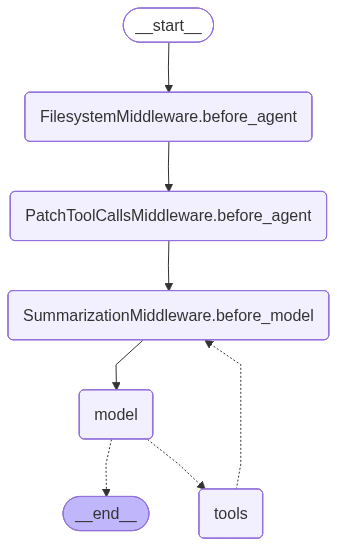

In [10]:
from deepagents import create_deep_agent

agent = create_deep_agent(
    model=model,
    system_prompt=INSTRUCTIONS,
    tools=sub_agent_tools,
    subagents=[sql_code_generator_sub_agent]
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

**Explanation:**
- **Model configuration**: Low temperature (0.0) for consistent, deterministic outputs
- **Multi-agent architecture**: Main agent delegates to specialized SQL sub-agent
- **Tool registration**: Makes both SQL generation and thinking tools available
- **DeepAgents integration**: Uses custom framework for agent orchestration

---

### 6. Database Execution Layer

#### 6.1 SQL Execution Function

In [ ]:
def QueryTheDatabaseAndShowTheOutput(sql_code: str):
    """
    Execute a read-only PostgreSQL SQL query and print the results.
    If a description is present before the SQL code, ignore it and execute only the SQL.
    """

    sql_code = sql_code.strip()

    # Remove markdown code blocks if present
    if sql_code.startswith("```sql"):
        sql_code = sql_code[6:].strip()
    elif sql_code.startswith("```"):
        sql_code = sql_code[3:].strip()
    if sql_code.endswith("```"):
        sql_code = sql_code[:-3].strip()

    # Sometimes the agent may include a description before the SQL, e.g.:
    # The SQL generated retrieves... \n SELECT ...
    # We'll look for the first line with 'select' or 'with' or other SQL starters
    content_lines = sql_code.split('\n')
    start_idx = 0
    for i, line in enumerate(content_lines):
        lower = line.strip().lower()
        # Handle start of common SQL statements
        if lower.startswith(("select", "with", "show", "explain", "describe")):
            start_idx = i
            break
    sql_code = '\n'.join(content_lines[start_idx:]).strip()

    # Basic safety: refuse destructive SQL
    dangerous_keywords = ("drop ", "truncate ", "delete ", "update ", "insert ")
    lower_sql = sql_code.strip().lower()
    if any(lower_sql.startswith(k) for k in dangerous_keywords):
        raise ValueError(f"Refusing to execute potentially destructive SQL: {sql_code!r}")

    # Connection to database
    conn = psycopg2.connect(
        host="aws-1-***.pooler.supabase.com",
        port=5432,
        database="postgres",
        user="postgres.***",
        password="***"
    )

    try:
        # Use DictCursor so we get column names
        cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

        cur.execute(sql_code)
        rows = cur.fetchall()

     ###### Print results ######
        if not rows:
            print("Query returned 0 rows.")
            return rows

        # Convert to pandas DataFrame for clean display
        col_names = list(rows[0].keys())
        data = []
        for row in rows:
            data.append([row[col] for col in col_names])
        
        df = pd.DataFrame(data, columns=col_names)
        
        # Display the DataFrame with nice formatting
        print(f"\n✓ Query returned {len(df)} row(s)\n")
        display(df)
        
       # return rows
    finally:
        cur.close()
        conn.close()


**Explanation:**
- **Markdown cleaning**: Removes code block syntax that the AI might add
- **Safety checks**: Blocks dangerous SQL operations before execution
- **Connection pooling**: Uses Supabase's pooler for better performance
- **DictCursor**: Preserves column names in results
- **Pandas integration**: Converts raw database results to clean, formatted tables
- **Resource management**: Properly closes database connections in `finally` block

#### 6.2 Main Execution Function

In [12]:
def RunUserRequest(user_request: str):
    # Step 1: ask the agent to generate SQL
    result = agent.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": user_request,
                }
            ],
        }
    )

    # Depending on how deepagents returns, extract the last message content
    messages = result["messages"]
    last_msg = messages[-1]
    sql_code = last_msg.content # expecting the agent to output only SQL
    
    print("Generated SQL:")
    print(sql_code)
    print("\nExecuting...\n")

    return sql_code

# Example 1:
sql_code = RunUserRequest("Show me all account columns that have an account level greater than 2 and a parent ID.")
QueryTheDatabaseAndShowTheOutput(sql_code)

Generated SQL:
Here is the SQL code to retrieve all columns from the 'accounts' table where the account level is greater than 2 and there is a parent ID present:

```sql
SELECT * FROM accounts WHERE account_level > 2 AND parent_id IS NOT NULL;
```

Executing...


✓ Query returned 12 row(s)



,account_id,account_name,account_level,parent_id,is_active,description,account_level_no,date_create
0,aea3c6b5-104d-49f2-bfa8-cea5b52da157,Bank_test,3,4c1abeeb-8645-4c79-80d8-89e772d496a3,True,None,6011,2025-11-08 13:15:34
1,edfa410c-8c41-4044-b0a9-2c9d414a82ad,Computer_test,3,0b64300a-da4f-4e01-8bba-fa626cc2ed9b,True,None,6021,2025-11-08 13:17:35
2,6f899c7f-9b15-49f5-b32c-1f0dd77d7c69,Furnichair_test,3,0b64300a-da4f-4e01-8bba-fa626cc2ed9b,True,None,6022,2025-11-08 13:18:05
3,0aa0f217-4a82-4af3-b771-ab142e48b49e,Developer_test,3,e1d09f52-b587-4c34-b4aa-1d44729864c1,True,None,7011,2025-11-08 13:19:54
4,8c23049e-b438-4ed9-8198-9d68cce835ff,Manager_test,3,e1d09f52-b587-4c34-b4aa-1d44729864c1,True,None,7012,2025-11-08 13:20:18
5,3c3bd13c-8438-4530-93ce-70d9b24f0643,Advertizer_test,3,e1d09f52-b587-4c34-b4aa-1d44729864c1,True,None,7013,2025-11-10 10:47:03
6,0456d450-5a5b-4a7b-a15b-c5876b507277,Test_BTR,3,dddb0dec-24d2-4b10-8250-7377842b9d6f,True,Related to bus,9011,2025-11-10 11:04:04
7,fb9cf743-251b-40c3-b457-6f85e74a9e10,Test_BTS,3,dddb0dec-24d2-4b10-8250-7377842b9d6f,True,None,9012,2025-11-10 11:07:23
8,265f6e60-a60f-4bf6-b251-9b4587163970,developer_test_KA,4,0aa0f217-4a82-4af3-b771-ab142e48b49e,True,None,70111,2025-11-10 10:44:54
9,48e58de4-a828-4bba-86bd-5dd2ea2f35f1,Advertizar_test_Kateb,4,3c3bd13c-8438-4530-93ce-70d9b24f0643,True,None,70131,2025-11-10 10:47:45


In [14]:
# Example 2:
sql_code = RunUserRequest("Drop all account columns that haven`t a parent ID.")
QueryTheDatabaseAndShowTheOutput(sql_code)

Generated SQL:
Could you please clarify if you want to drop entire rows from the accounts table where the parent ID is NULL, or if you are looking to drop specific columns?

Executing...



SyntaxError: syntax error at or near "Could"
LINE 1: Could you please clarify if you want to drop entire rows fro...
        ^


**Explanation:**
- **Agent invocation**: Triggers the entire AI agent pipeline
- **Response parsing**: Extracts SQL code from the agent's final message
- **Workflow separation**: Separates SQL generation from execution for flexibility
- **Example usage**: Demonstrates the complete end-to-end process

---

## 🛡️ Security Measures

### Read-Only Enforcement
The system includes a pre-execution check to prevent accidental data loss. The following keywords trigger a `ValueError` and stop execution:
*   `DROP`
*   `TRUNCATE`
*   `DELETE`
*   `UPDATE`
*   `INSERT`

### Connection Pooling
The system connects via the Supabase Transaction Pooler (Port 6543/5432) to handle IPv4/IPv6 compatibility and manage connection limits efficiently.

---

## ⚠️ Troubleshooting

**Issue: `OperationalError: could not translate host name`**
*   **Fix:** Ensure you are using the **Session Pooler** URL from Supabase settings, not the direct URL. The Pooler handles IPv4 networks correctly.

---